# 导包

In [1]:
#导包
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,Multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from tensorflow.keras.losses import MeanSquaredError
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os 
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用 GPU 1
# from model import create_model
from evaluate import look_loss
from evaluate import all_estimate

gc.collect()

2025-04-22 18:46:18.985124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 18:46:19.377699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745318779.799245    6896 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745318779.903830    6896 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745318780.368096    6896 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

23

# 数据处理

In [ ]:
depth = [5.1, 18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]
data_st_processed = np.load(r'./data_st_processed.npy')
data_surface_processed = np.load(r'./data_surface_processed.npy')
data_surface = data_surface_processed

data_input = data_surface

data_st = data_st_processed[0:132,:,:,:]
data_underwater1 = np.load(r'./with_noise/rate95_5/layer1_pred_data.npy')
data_underwater2 = np.load(r'./with_noise/rate95_5/layer2_pred_data.npy')
data_underwater3 = np.load(r'./with_noise/rate95_5/layer3_pred_data.npy')
data_underwater4 = np.load(r'./with_noise/rate95_5/layer4_pred_data.npy')
data_underwater5 = np.load(r'./with_noise/rate95_5/layer5_pred_data.npy')
data_underwater6 = np.load(r'./with_noise/rate95_5/layer6_pred_data.npy')
data_underwater7 = np.load(r'./with_noise/rate95_5/layer7_pred_data.npy')
data_underwater8 = np.load(r'./with_noise/rate95_5/layer8_pred_data.npy')
data_underwater9 = np.load(r'./with_noise/rate95_5/layer9_pred_data.npy')
data_underwater = np.concatenate((data_underwater1, data_underwater2,data_underwater3,data_underwater4,data_underwater5,data_underwater6,data_underwater7,data_underwater8
                                  ,data_underwater9), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[:,:,:,9:10] #(132,  100，160， 1)
print(out_data_y.shape)

(132, 108, 168, 5) (132, 100, 160, 20)
(132, 100, 160, 1)


In [3]:
print('----------------for layer10_ST--------------------')

time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

----------------for layer10_ST--------------------
(132, 100, 160, 9, 9, 14)


In [4]:
# 修改变量形状
out_data_reshape = out_data.reshape((132,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
# nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,channel-1:channel]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)
    

(132, 16000, 9, 9, 14)
(132, 16000, 9, 9, 14)
(16000, 81)


In [5]:
out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_y_reshape = out_data_y_reshape.reshape(-1,132,1)
print('out_data_y_reshape:',out_data_y_reshape.shape)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于1时
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)
    

out_data_reshape: (16000, 132, 9, 9, 14)
out_data_y_reshape: (100, 160, 132, 1)
out_data_y_reshape: (16000, 132, 1)


In [6]:
print(nan_mask2)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [7]:
nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]


In [8]:
out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

In [9]:
out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)

# 最后十二个月的数据作为test
test_num = 120
x_train = out_data_reshape[:test_num]
y_train = out_data_y_reshape[:test_num]

x_test = out_data_reshape[test_num:]
y_test = out_data_y_reshape[test_num:]

# 将前两个维度进行合并  时间*(lat*lon)
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))

y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=100)

out_data_reshape: (132, 14783, 9, 9, 14)
out_data_y_reshape: (132, 14783, 1)


In [10]:
# 记录数据集的形状
x_train_shape = x_train.shape
y_train_shape = y_train.shape

x_test_shape = x_test.shape
y_test_shape = y_test.shape

x_val_shape = x_val.shape
y_val_shape = y_val.shape


In [11]:
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train_shape[3])) 
x_test = scaler_f.transform(x_test.reshape(-1,x_test_shape[3]))
x_val = scaler_f.transform(x_val.reshape(-1,x_val_shape[3]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,y_train_shape[1])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[1])) 
y_val = scaler_l.transform(y_val.reshape(-1,y_val_shape[1])) 

In [12]:
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))
x_val = np.reshape(x_val,(-1,9,9,channel))
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))
y_val = np.reshape(y_val,(-1,1))

# 模型训练

# 无注意力机制

In [13]:
# 使用自定义注意力层
def create_model(neurons1, neurons2):
    # 第一部分输入
    model_input = Input(shape=x_train.shape[1:3] + (5,))
    x = Conv2D(filters=neurons1, kernel_size=(3, 3), strides=1)(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv2D(filters=neurons2, kernel_size=(3, 3), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    # x = Dense(units=16, activation='relu')(x)

    # 第二部分输入
    model_input2 = Input(shape=x_train.shape[1:3] + (9,))


    # 第二部分卷积网络
    x1 = Conv2D(filters=32, kernel_size=(3, 3), strides=1)(model_input2)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv2D(filters=64, kernel_size=(3, 3), strides=1)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Flatten()(x1)
    x1 = Dense(units=8, activation='relu')(x1)
    # x1 = Dense(units=16, activation='relu')(x1)
    
    # 正确写法（方法1）
    concatenated = Concatenate(axis=-1)([
        Lambda(lambda x: 0.95 * x)(x),
        Lambda(lambda x: 0.05 * x)(x1)
    ])

    # 后续层
    # concatenated = Dense(32, activation='relu')(concatenated)
    concatenated = Dense(units=32, activation='relu')(concatenated)
    concatenated = Dense(units=16, activation='relu')(concatenated)
    

    # # 输出层
    out = Dense(units=1)(concatenated)
    
    # out = Dense(units=1)(x1)
    

    # 创建模型
    model = Model(inputs=[model_input, model_input2], outputs=out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# 创建模型
model = create_model(128, 256)

# 回调函数
checkpoint_path = 'layer10_no_95_5/CNN_model_layer10_st_no.keras'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


# 训练模型
num_epochs = 200
batch_size = 2048
# history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:14]], y_train,
                    # validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:14]], y_val),
                    # epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=[keras_callbacks, OutputCallback()])
                    
history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:14]], y_train,
                    validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:14]], y_val),
                    epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=keras_callbacks)

I0000 00:00:1745319052.986773    6896 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9


Epoch 1/200


I0000 00:00:1745319089.503208    7293 service.cc:152] XLA service 0x7f3f6002dc40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745319089.503316    7293 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-22 18:51:29.920384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745319091.221961    7293 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-22 18:51:32.588859: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489', 144 bytes spill stores, 144 bytes spill loads

2025-04-22 18:51:32.710436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

607/607 - 67s - 111ms/step - loss: 0.0366 - val_loss: 0.0184
Epoch 2/200
607/607 - 18s - 30ms/step - loss: 0.0158 - val_loss: 0.0181
Epoch 3/200
607/607 - 18s - 30ms/step - loss: 0.0146 - val_loss: 0.0171
Epoch 4/200
607/607 - 21s - 35ms/step - loss: 0.0139 - val_loss: 0.0108
Epoch 5/200
607/607 - 18s - 30ms/step - loss: 0.0137 - val_loss: 0.0108
Epoch 6/200
607/607 - 18s - 30ms/step - loss: 0.0135 - val_loss: 0.0111
Epoch 7/200
607/607 - 21s - 34ms/step - loss: 0.0139 - val_loss: 0.0110
Epoch 8/200
607/607 - 18s - 29ms/step - loss: 0.0131 - val_loss: 0.0113
Epoch 9/200
607/607 - 18s - 30ms/step - loss: 0.0132 - val_loss: 0.0114
Epoch 10/200
607/607 - 21s - 34ms/step - loss: 0.0131 - val_loss: 0.0112
Epoch 11/200
607/607 - 18s - 30ms/step - loss: 0.0130 - val_loss: 0.0155
Epoch 12/200
607/607 - 21s - 34ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 13/200
607/607 - 18s - 29ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 14/200
607/607 - 18s - 30ms/step - loss: 0.0127 - val_loss: 0.013

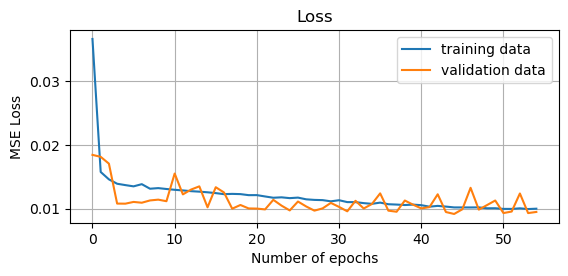

5544/5544 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step
Test RMSE: 0.204
acc: 97.85038
R² score: 0.9573789238929749


In [14]:
look_loss(history)
best_model1 = tf.keras.models.load_model('layer10_no_95_5/CNN_model_layer10_st_no.keras',      safe_mode=False)
all_estimate(best_model1,[x_test[:,:,:,0:5], x_test[:,:,:,5:14]], y_test)#x_test[:,:,:,0:5], x_test[:,:,:,5:14], y_test

In [15]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer10_no_95_5/CNN_model_layer10_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:14]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer10_st = scaler_l.inverse_transform(result)
y_test_layer10_unscaled = scaler_l.inverse_transform(y_test)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 58s 10ms/step


In [16]:
r2 = r2_score(y_test_layer10_unscaled[:,0],predict_layer10_st[:,0])
print('layer10 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer10_unscaled[:,0]-predict_layer10_st[:,0])))
print('layer10 Test mae: %.3f' % mae)

layer10 R² score: 0.9573789238929749
layer10 Test mae: 0.560


Results written to results.txt
[[20.70791817 20.96132851 21.0458622  ... 19.68896675 19.79990768
  19.92625618]
 [20.90374565 21.08372307 21.1062355  ... 19.98983955 20.13398933
  20.25687218]
 [20.96687317 21.03658104 21.03683662 ... 20.2757988  20.39180756
  20.50877571]
 ...
 [ 6.45708847  6.0011673   5.95397472 ... 13.08769512 13.17011929
  13.17852306]
 [ 5.84529781  5.08378601  4.71074104 ... 12.21327305 12.23016262
  12.12224102]
 [        nan         nan  3.59211993 ... 10.73000717 10.74359035
  10.50328541]]


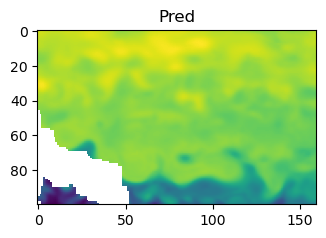

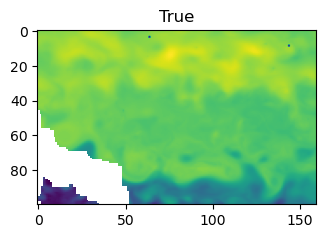

[[19.50654602 19.60103226 19.66182518 ... 18.77263641 18.92498589
  19.0055542 ]
 [19.73067474 19.82735634 19.88082504 ... 18.85393906 19.02752686
  19.15057755]
 [19.98190308 20.08810616 20.13864517 ... 18.90594101 19.08612251
  19.25312042]
 ...
 [ 3.74581122  3.60664725  4.12082291 ... 12.72923946 12.87353134
  12.90942097]
 [ 2.49040198  2.4611032   2.36149192 ... 11.8781395  12.04806709
  12.04953194]
 [        nan         nan  0.83068353 ... 10.66447926 10.70329952
  10.63225174]]


3429

In [17]:
predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer10_st
true_data[non_nan_mask] = y_test_layer10_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer10_no_95_5/results.txt", "w") as file:
    file.write(f"layer10 R² score: {r2}\n")
    file.write(f"layer10 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer10_no_95_5/predict_data.npy',predict_data)
np.save(r'./layer10_no_95_5/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()